# ACM40960

### 1. Load relevant libraries

In [355]:
import pandas as pd
from pandas import DataFrame
import glob
import math
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import linear_model
import mord
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import boxcox as spboxcox
from scipy.special import inv_boxcox
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from collections import Counter
import random
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier as boost
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier as adaboost
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import OneHotEncoder

### 2. Load the data

Load the data from all csv files in the Data folder, and merge into a single data frame

In [3]:
# Define data files path name
path = 'Data/'

# Get file names of all csv files in the Data folder
filenames = sorted(glob.glob(path + "/*.csv"))

# create empty list to store data frames from each EPL season
li = []

# loop through all csv file names
for filename in filenames:
    # read in 'HomeTeam', 'AwayTeam', 'FTR' columns for current file, drop rows with NAs
    df = pd.read_csv(filename, usecols=['HomeTeam', 'AwayTeam', 'FTR']).dropna()
    # append dataframe from current EPL year to list
    li.append(df)

# combine all data frames in list into a single data frame
EPL_original = pd.concat(li, axis=0)

# create copy of the EPL data frame so we can keep the originally loaded data frame if needed later
EPL = EPL_original.copy()

# reset row indices
EPL.reset_index(drop=True, inplace=True)

### 3. Define miscellaneous functions

Define logit and logistic functions for transforming the data where appropriate

In [4]:
# logit transformation function
def logit_tf(p):
    return np.log(p / (1-p))

# logistic transformation function
def logistic_tf(x):
    return 1 / (1 + np.exp(-x))

### 4. Calculate known metrics from the data

Calculate total number of points earned by each team each in the current season, and results obtained for each team in each fixture of each season. 

Then add new columns to EPL data frame for both home and away teams, containing:

- proportion of total number of points achieved in the current season,
- proportion of total number of points achieved last season where possible (not possible for newly promoted teams),
- proportion of possible points achieved in the past 5 games where possible (not possible for teams' first 5 games of each season)
- appropriated scaled versions of all these columns (e.g. logit transformations of the proportion of total number of points achieved columns)

In [5]:
%%time

# get no. of seasons (number of files loaded)
num_seasons = len(filenames)
# get no. of games per season (20 teams choose 2, multiply by 2 for home/away fixtures)
games_per_season = math.comb(20, 2) * 2

# add column to store season integer, set all to 0 initially
EPL.insert(0,"Season",0)
# add columns to EPL to store '% of total points earned for the whole season' for home and away teams 
EPL['HomePPC'] = np.nan
EPL['AwayPPC'] = np.nan
## add columns to EPL to store '% of total points earned for the whole season from LAST YEAR' for home and away teams 
EPL['HomePPCprev'] = np.nan
EPL['AwayPPCprev'] = np.nan
## add columns to EPL to store form values for home and away teams (% points in past 5 games)
EPL['HomeForm5'] = np.nan
EPL['AwayForm5'] = np.nan

# set start/end indices for the first season of fixtures
start_ind = 0
end_ind = games_per_season
# set number of games to include for form (use 5 as default)
form_games = 5

# create empty dataframes to save season stats, PPG and form stats for every team for all seasons
all_seasons_WLD = DataFrame()
all_seasons_ppg = DataFrame()
all_seasons_form = DataFrame()

# loop through all 25 seasons worth of data
for season in range(0,num_seasons):
    # get list of unique teams in the current season
    teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    
    ## create data frame to store points in each game
    teams_ppg = DataFrame(columns=range(1,39))
    teams_ppg.insert(0,"Team",teams)
    ## create data frame to store 5 game form
    teams_form = DataFrame(columns=range(1,39))
    teams_form.insert(0,"Team",teams)
    
    # loop through all teams in the current season
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
        Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
        Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        
    # sort by highest points
    teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    
    # add column for current season index
    teams_WLD.insert(0,"Season",season)
    teams_ppg.insert(0,"Season",season)
    teams_form.insert(0,"Season",season)
    
    # loop through each fixture in the current season
    for game in range(start_ind,end_ind):
        # add current season integer to the EPL dataframe
        EPL.at[game,'Season']=season
        # add overall points % for the home and away teams in the current fixture
        home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
        away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
        EPL.at[game,'HomePPC']=home_pc
        EPL.at[game,'AwayPPC']=away_pc
        
        # if Season>0, check if home/away team in each fixture was in league last season and
        # add last seasons overall points % if so
        if season>0:
            teams_WLD_prev = all_seasons_WLD[all_seasons_WLD['Season']==(season-1)]
            # check if current fixture home team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['HomeTeam'])):
                home_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
                EPL.at[game,'HomePPCprev']=home_pc_prev
                
            # check if current fixture away team were in league last season
            if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['AwayTeam'])):
                away_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
                EPL.at[game,'AwayPPCprev']=away_pc_prev
        
        ## Get home and away team names
        hometeam = EPL.iloc[game,]['HomeTeam']
        awayteam = EPL.iloc[game,]['AwayTeam']
        ## determine points for home and away team (will remain 0 if team has lost)
        HomePts = AwayPts = 0
        if EPL.iloc[game,]['FTR'] == 'D':
            HomePts = AwayPts = 1
        elif EPL.iloc[game,]['FTR'] == 'H':
            HomePts = 3
        else :
            AwayPts = 3
        
        ## get next available game index of home team, add home team points to teams_ppg dataframe
        home_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==hometeam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==hometeam, home_nextfree] = HomePts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if home_nextfree > form_games:
            home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-(form_games-1)):(home_nextfree+1)].values.sum()
            teams_form.loc[teams_WLD['Team']==hometeam, home_nextfree] = home_form5
            EPL.at[game,'HomeForm5'] = home_form5
        
        ## get next available game index of away team, add away team points to teams_ppg dataframe
        away_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==awayteam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==awayteam, away_nextfree] = AwayPts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if away_nextfree > form_games:
            away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-(form_games-1)):(away_nextfree+1)].values.sum()
            teams_form.loc[teams_WLD['Team']==awayteam, away_nextfree] = away_form5
            EPL.at[game,'AwayForm5'] = away_form5
 
    # add current season stats for each team to main dataframe
    all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
    all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
    all_seasons_form = all_seasons_form.append(teams_form)
    
    # increment start/end indices to correspond with fixtures for next season
    start_ind = start_ind + games_per_season
    end_ind = end_ind + games_per_season

CPU times: user 1min 46s, sys: 413 ms, total: 1min 46s
Wall time: 1min 47s


### 5. Visualise the original data

Define function for plotting dots with colour and size proportional to correlation coefficient value, which can be used to visulaise correlation between variables on a PairGrid pairs plot.

In [6]:
def corrdot(*args, **kwargs):
    corr_r=args[0].corr(args[1], 'pearson')
    corr_text=f"{corr_r:2.2f}".replace("0.", ".")
    ax=plt.gca()
    ax.set_axis_off()
    marker_size=abs(corr_r)*10000
    ax.scatter([.5],[.5],marker_size,[corr_r],alpha=0.6,cmap="coolwarm",
              vmin=-1, vmax=1, transform=ax.transAxes)
    font_size=abs(corr_r)*40+5
    ax.annotate(corr_text, [.5, .5,], xycoords="axes fraction",
               ha='center', va='center', fontsize=font_size)

Create pairs plot of all columns in the EPL data frame, with scatter plots and regression line shown on lower triangle, density plots shown on the diagonal and correlation dots shown on the upper triangle in the grid of plots.

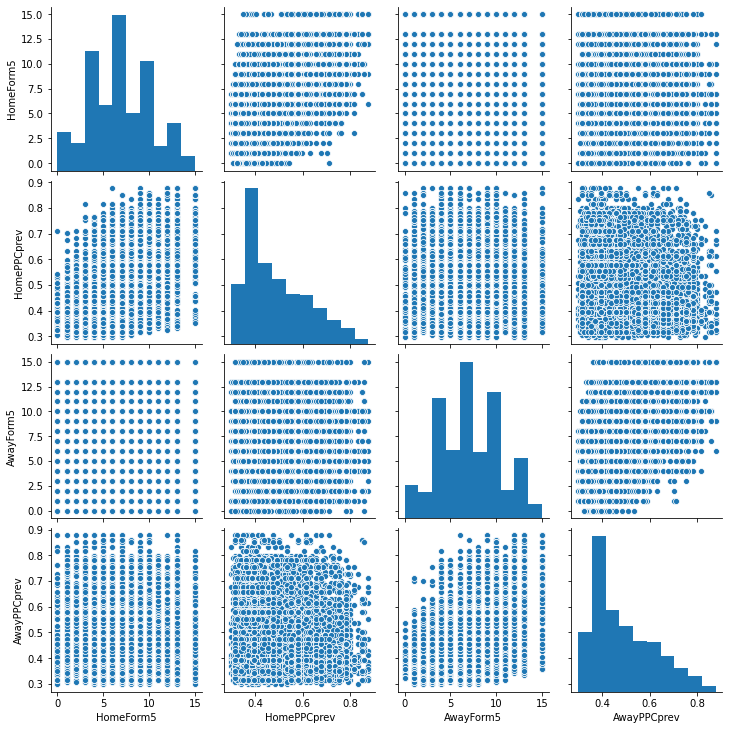

In [7]:
sns.pairplot(EPL[['HomeForm5','HomePPCprev', 'AwayForm5', 'AwayPPCprev']])

In [8]:
# get optimum lambda values for boxcox transformations of home and away PPC previous data
home_lambda = boxcox(EPL['HomePPCprev'].dropna())[1]
away_lambda = boxcox(EPL['AwayPPCprev'].dropna())[1]

In [9]:
# create new columns with boxcox transformed Home/AwayPPCprev data
EPL['HomePPCprev_tf'] = spboxcox(EPL['HomePPCprev'], home_lambda)
EPL['AwayPPCprev_tf'] = spboxcox(EPL['AwayPPCprev'], away_lambda)

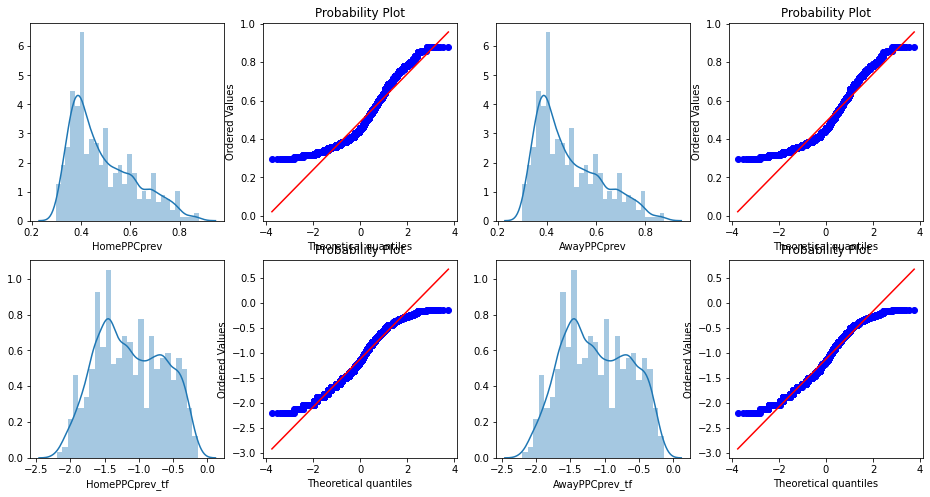

In [10]:
# set up plot size to plot 8 separate plot (2 rows of 4 plots), each of size 4x4
plt.figure(figsize=(16,8))

# plot distribution and QQ-plot for original PPCprev data
ax1 = plt.subplot(241)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(242)
plot2 = probplot(EPL['HomePPCprev'].dropna(), dist=norm, plot=plt)
ax3 = plt.subplot(243)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(244)
plot4 = probplot(EPL['AwayPPCprev'].dropna(), dist=norm, plot=plt)

# plot distribution and QQ-plot for boxcox transformed PPCprev data
ax5 = plt.subplot(245)
plot5 = sns.distplot(EPL['HomePPCprev_tf'])
ax6 = plt.subplot(246)
plot6 = probplot(EPL['HomePPCprev_tf'].dropna(), dist=norm, plot=plt)
ax7 = plt.subplot(247)
plot7 = sns.distplot(EPL['AwayPPCprev_tf'])
ax8 = plt.subplot(248)
plot8 = probplot(EPL['AwayPPCprev_tf'].dropna(), dist=norm, plot=plt)

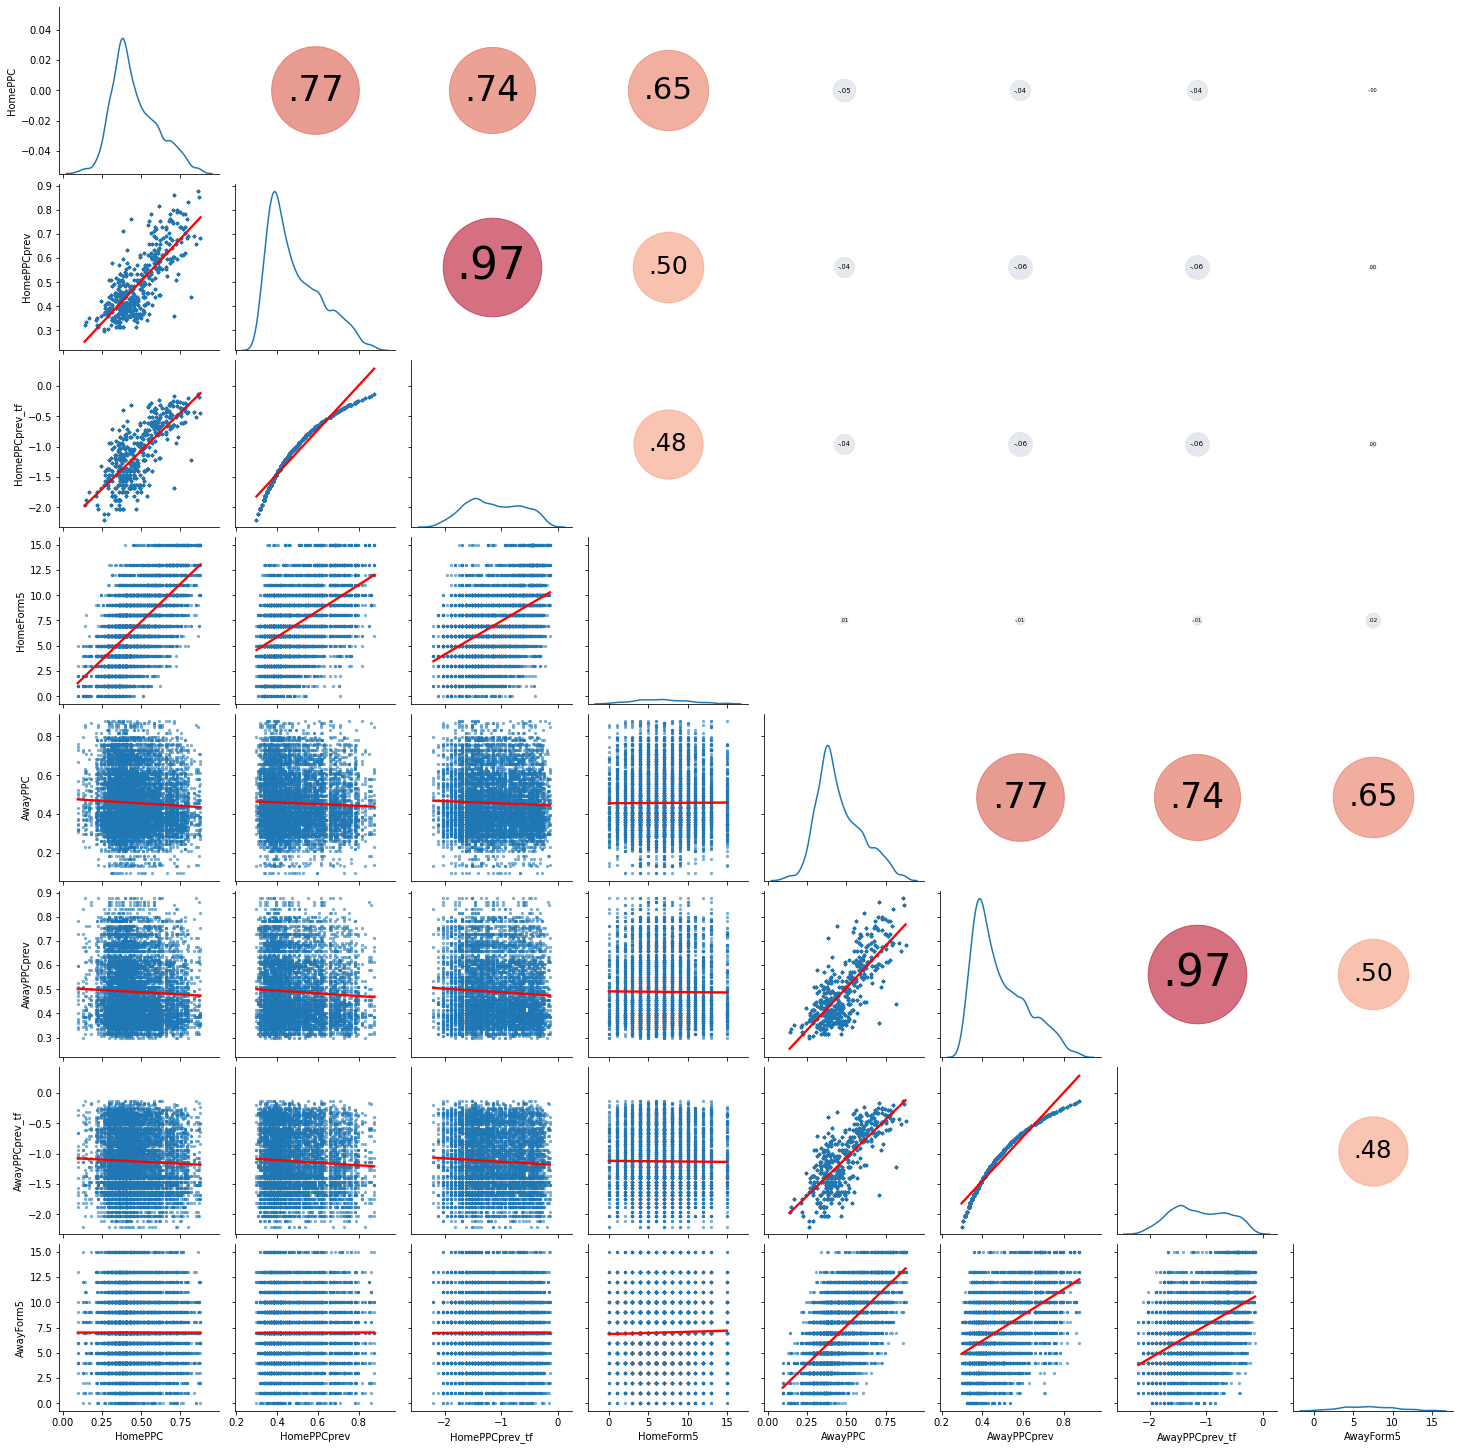

In [11]:
g=sns.PairGrid(EPL[['HomePPC','HomePPCprev','HomePPCprev_tf','HomeForm5','AwayPPC','AwayPPCprev','AwayPPCprev_tf','AwayForm5']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

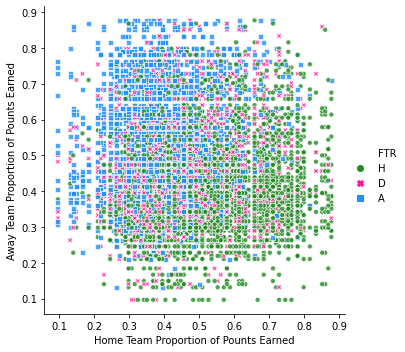

In [13]:
a=sns.relplot(data=EPL, x='HomePPC', y='AwayPPC', 
              hue='FTR', style='FTR', kind='scatter', 
              s=25, alpha=0.8,
            palette=dict(H='forestgreen', 
                         D='deeppink', 
                         A='dodgerblue')).set(xlabel='Home Team Proportion of Pounts Earned',
                                             ylabel='Away Team Proportion of Pounts Earned')

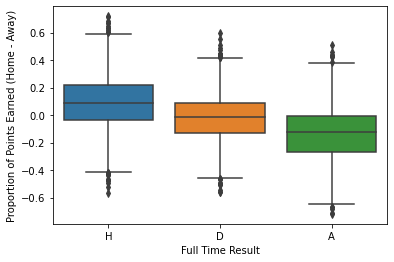

In [14]:
a=sns.boxplot(EPL['FTR'], 
              EPL['HomePPC']-EPL['AwayPPC']).set(xlabel='Full Time Result', 
                                                 ylabel='Proportion of Points Earned (Home - Away)',
                                                title='')

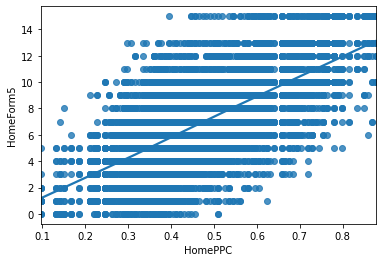

In [15]:
sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], lowess=True)

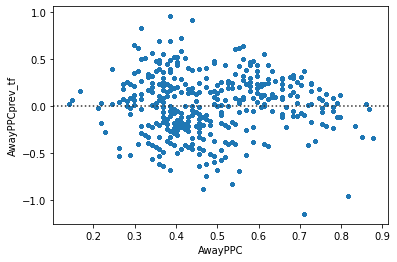

In [17]:
sns.residplot(EPL['AwayPPC'], EPL['AwayPPCprev_tf'],
            scatter_kws={'alpha':0.8, 's':10}, line_kws={'color':'red'})

### 6. Impute unavailable values for points in previous season and form

There are several cases where it was not possible to calculate the proportion of points earned by a team in the previous year (i.e. cases where teams are newly promoted, and for all teams in the first available season) and the form value over the past 5 games (i.e. first 5 games for each team each season).

From the correlation dots on the pairs plot above (and as would be expected), we can see that there is a relatively strong correlation between the proportion of points earned by teams in the current season and they're 5 game form value, so it seems reaonable to use the home and away proportion of points earned in the current season to impute the unknown values of 5 game home form and away form respectively. As there are only a finite number of possible form values that a team can have, and they are bounded between 0 and 15, I will use ordinal logistic regression to estimate the probabilities for each unknown form value of being each of the possible 15 values, and I will randomly sample from these probabilities as an estimate of the unknown form value (rather than choosing most probable value, to preserve variance in the data).

Likewise, there is a similarly strong correlation between the proportion of points earned by teams in the current season and the proportion of points they earned in the previous season. We can use this relationship to impute values for the unknown proportion of points earned in the previous year values using simple linear regression.

In [19]:
print(EPL['HomePPC'].corr(EPL['HomeForm5']))
print(EPL['AwayPPC'].corr(EPL['AwayForm5']))

0.6454406984758209
0.6505244996144792


In [20]:
print(EPL['HomePPC'].corr(EPL['HomePPCprev_tf']))
print(EPL['AwayPPC'].corr(EPL['AwayPPCprev_tf']))

0.7416225709613654
0.7416225723584337


#### 6.1 Imputing unavailable form values

We will use the proportion of points earned by teams in the current season to impute their form values in cases where the form values couldn't be calculated. First we can effectively create training and test sets for the data, where training sets include HomePPC/AwayPPC and HomeForm5/AwayForm5 values for all cases where the HomeForm5/AwayForm5 values are available, and test sets include the HomePPC/AwayPPC values for the remaining cases where HomeForm5/AwayForm5 values are not available.

After training separate models for the home and away data, the predicted probabilities of belonging to each 'class' (i.e. 0,1,..,12,13,15) for each item in the test data is calculated, and the final estimated value in each case is obtained by randomly sampling the class value based on the associated class probabilities.

In [21]:
# split home form and PPC data into train and test (test will be all NaN values in HomeForm5 column)
home_x_test = EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomePPC']]
home_x_train = EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomePPC']]
home_y_train = (EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomeForm5']]).values.squeeze()

# split away form and PPC data into train and test (test will be all NaN values in AwayForm5 column)
away_x_test = EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayPPC']]
away_x_train = EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayPPC']]
away_y_train = (EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayForm5']]).values.squeeze()

In [22]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

In [23]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))
# generate class probabilities for the test data from the model
home_y_predprobs = ord_reg_home.predict_proba(home_x_test)

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))
# generate class probabilities for the test data from the model
away_y_predprobs = ord_reg_away.predict_proba(away_x_test)

In [24]:
# create list of possible form values (integers from 0 to 15 but with 14 omitted)
classlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]

# create 1d arrays of zeros to store estimated form values
home_y_pred = np.zeros(home_y_predprobs.shape[0])
away_y_pred = np.zeros(away_y_predprobs.shape[0])

# set seed
np.random.seed(20203868)

# loop through all rows of the predicted probabilities array 
for i in range(home_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = home_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    home_y_pred[i] = np.random.choice(classlist, 1, p=problist)
    
# loop through all rows of the predicted probabilities array 
for i in range(away_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = away_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    away_y_pred[i] = np.random.choice(classlist, 1, p=problist)

In [25]:
print('Home Training Data:\nMean = %.2f, Variance = %.2f' %(np.mean(home_y_train), np.var(home_y_train)))
print('\nHome Test Data:\nMean = %.2f, Variance = %.2f' %(np.mean(home_y_pred), np.var(home_y_pred)))

Home Training Data:
Mean = 6.73, Variance = 11.21

Home Test Data:
Mean = 6.82, Variance = 11.76


In [26]:
print('Away Training Data:\nMean = %.2f, Variance = %.2f' %(np.mean(away_y_train), np.var(away_y_train)))
print('\nAway Test Data:\nMean = %.2f, Variance = %.2f' %(np.mean(away_y_pred), np.var(away_y_pred)))

Away Training Data:
Mean = 7.00, Variance = 11.13

Away Test Data:
Mean = 6.86, Variance = 10.79


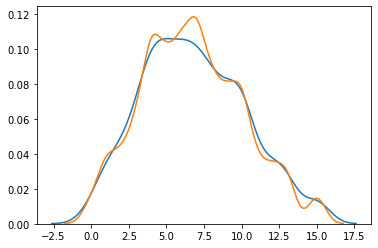

In [27]:
sns.kdeplot(home_y_pred)
sns.kdeplot(home_y_train)

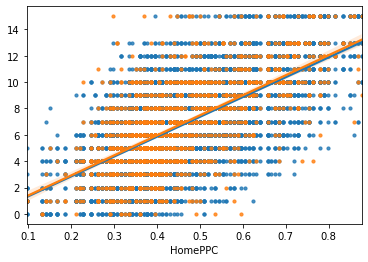

In [28]:
sns.regplot(home_x_train, home_y_train, scatter_kws={'alpha':0.8, 's':10})
sns.regplot(home_x_test, home_y_pred, scatter_kws={'alpha':0.8, 's':10})

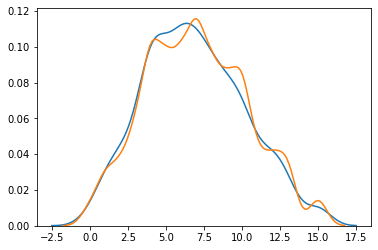

In [29]:
sns.kdeplot(away_y_pred)
sns.kdeplot(away_y_train)

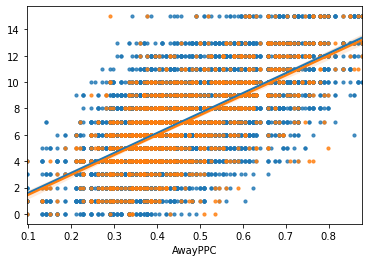

In [30]:
sns.regplot(away_x_train, away_y_train, scatter_kws={'alpha':0.8, 's':10})
sns.regplot(away_x_test, away_y_pred, scatter_kws={'alpha':0.8, 's':10})

In [31]:
EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomeForm5']] = home_y_pred
EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayForm5']] = away_y_pred

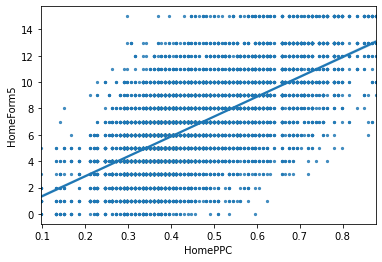

In [32]:
sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], scatter_kws={'s':5})

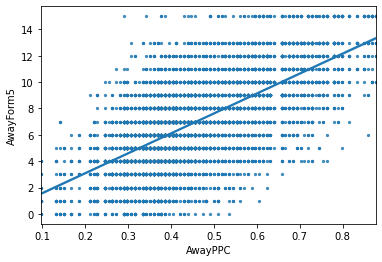

In [33]:
sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], scatter_kws={'s':5})

#### 6.2 Imputing unavailable Home/AwayPPCprev values

We will use the proportion of points earned by teams in the current season to impute the proportion of points they earned in the previous season in cases where these values couldn't be calculated. First we can effectively create training and test sets for the data. As  training sets include HomePPC and HomePPCprev_tf values for all cases where the HomePPCprev_tf values are available...

In [34]:
# split home form and PPC data into train and test (test will be all NaN values in HomePPCprev_tf column)
homep_x_test = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPC']]
homep_x_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPC']]
homep_y_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPCprev_tf']]

# split away form and PPC data into train and test (test will be all NaN values in AwayPPCprev_tf column)
awayp_x_test = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPC']]
awayp_x_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPC']]
awayp_y_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPCprev_tf']]

In [35]:
# fit linear regression model to home training data, predict values for the missing HomePPCprev values
regr_homep = linear_model.LinearRegression()
regr_homep.fit(homep_x_train, homep_y_train)
homep_y_pred = regr_homep.predict(homep_x_test)

# fit linear regression model to away training data, predict values for the missing AwayPPCprev values
regr_awayp = linear_model.LinearRegression()
regr_awayp.fit(awayp_x_train, awayp_y_train)
awayp_y_pred = regr_awayp.predict(awayp_x_test)

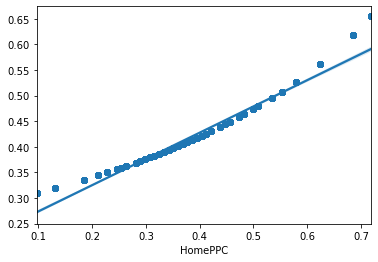

In [36]:
#sns.regplot(homep_x_test, homep_y_pred)
sns.regplot(homep_x_test, inv_boxcox(homep_y_pred, home_lambda))

In [37]:
# calculate standard error for known home PPCprev values (after logit transformation)
home_stderror = logit_tf(inv_boxcox(homep_y_train, home_lambda)).std()

# get data frame containing list of teams in each season with no PPCprev values
NoPPCprev = (EPL.loc[(EPL.loc[:,'HomePPCprev_tf'].isna()), ['Season', 'HomeTeam']]).drop_duplicates()

# set seed
np.random.seed(20203868)

# get random normal samples to add to predicted home/away PPC prev values 
# (with home PPCprev strandard error)
PPCprev_rand = np.random.normal(size = len(NoPPCprev), loc = 0, scale = home_stderror)
NoPPCprev['rand'] = PPCprev_rand

In [38]:
# get dataframe of all fixtures where home team has no PPCprev value
homep_NoPPCprev = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['Season', 'HomeTeam']]
# add predicted values for home teams' PPC prev after boxcox and logit transorming the data
homep_NoPPCprev['Pred'] = logit_tf(inv_boxcox(homep_y_pred, home_lambda))
# add column to store random values
homep_NoPPCprev['Rand'] = 0.0
# reset row indices
homep_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(homep_NoPPCprev.shape[0]):
    # get random normal value for the current home team/current season
    hometeam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==homep_NoPPCprev.iloc[game,]['HomeTeam']) &
    (NoPPCprev['Season']==homep_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    homep_NoPPCprev.at[game,'Rand'] = hometeam_rand

# add random normal noise to predicted values and perform logisitc transform
homep_NoPPCprev['PredRand'] = logistic_tf(homep_NoPPCprev['Pred'] + homep_NoPPCprev['Rand'])

In [39]:
# get dataframe of all fixtures where away team has no PPCprev value
awayp_NoPPCprev = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['Season', 'AwayTeam']]
# add predicted values for away teams' PPC prev
awayp_NoPPCprev['Pred'] = logit_tf(inv_boxcox(awayp_y_pred, home_lambda))
# add column to store random values
awayp_NoPPCprev['Rand'] = 0.0
# reset row indices
awayp_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(awayp_NoPPCprev.shape[0]):
    # get random normal value for the current away team/current season
    awayteam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==awayp_NoPPCprev.iloc[game,]['AwayTeam']) &
    (NoPPCprev['Season']==awayp_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    awayp_NoPPCprev.at[game,'Rand'] = awayteam_rand

# add random normal noise to predicted values and perform logisitc transform
awayp_NoPPCprev['PredRand'] = logistic_tf(awayp_NoPPCprev['Pred'] + awayp_NoPPCprev['Rand'])

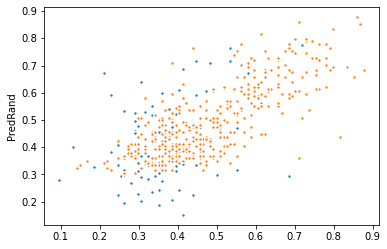

In [40]:
sns.scatterplot(np.array(awayp_x_test).squeeze(), awayp_NoPPCprev['PredRand'], s=10)
sns.scatterplot(np.array(awayp_x_train).squeeze(), np.array(inv_boxcox(awayp_y_train, away_lambda)).squeeze(), s=10)

In [41]:
# add values to the EPL data frame
EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPCprev_tf']] = boxcox(homep_NoPPCprev['PredRand'].values, home_lambda)
EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPCprev_tf']] = boxcox(awayp_NoPPCprev['PredRand'].values, away_lambda)

# add transformed values to the EPL data frame
# (inverse of boxcox transformations performed earlier)
EPL.loc[EPL.loc[:,'HomePPCprev'].isna(),['HomePPCprev']] = homep_NoPPCprev['PredRand'].values
EPL.loc[EPL.loc[:,'AwayPPCprev'].isna(),['AwayPPCprev']] = awayp_NoPPCprev['PredRand'].values

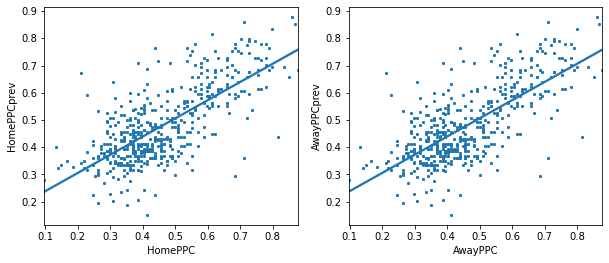

In [42]:
# set up plot size
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev'], scatter_kws={'s':1})
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev'], scatter_kws={'s':1})

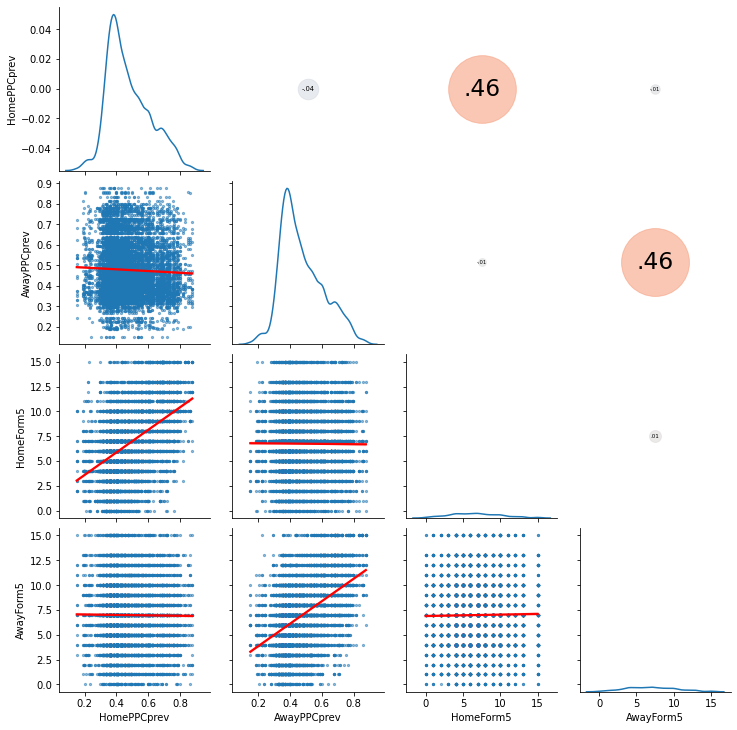

In [43]:
g=sns.PairGrid(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

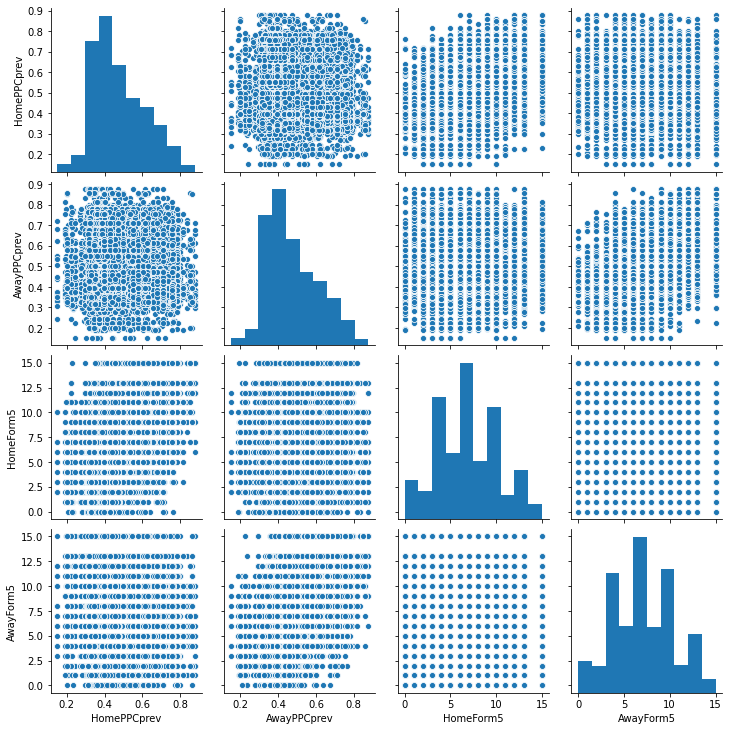

In [44]:
sns.pairplot(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])

If we look at QQ-plots again for the home and away form values (with the newly imputed values included) we can see that they both appear to follow an approximate normal distribution, though the tails cut off abruptly as expected due to the possible form values being bounded between 0 and 15.

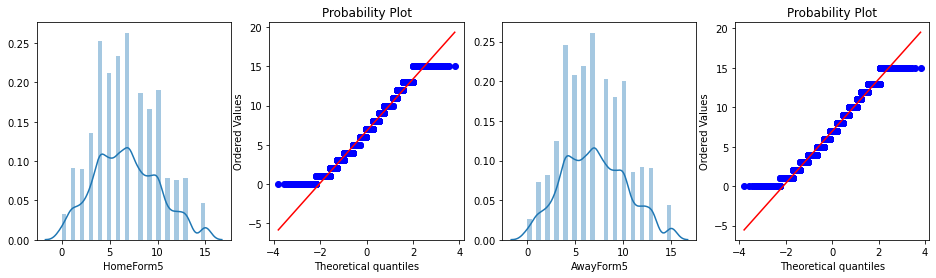

In [45]:
# set up plot size
plt.figure(figsize=(16,4))

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomeForm5'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomeForm5'], dist=norm, plot=plt)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayForm5'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayForm5'], dist=norm, plot=plt)

Likewise, looking at QQ-plots for the home and away PPC prev values (with the newly imputed values included) we can see that they also appear to roughly follow a normal distribution, although the distribution of the data deviates somewhat from this towards the tails. This is again likely due to the number of achieveable points in a season - and hence proportion of points obtained in the previous season - being bounded.

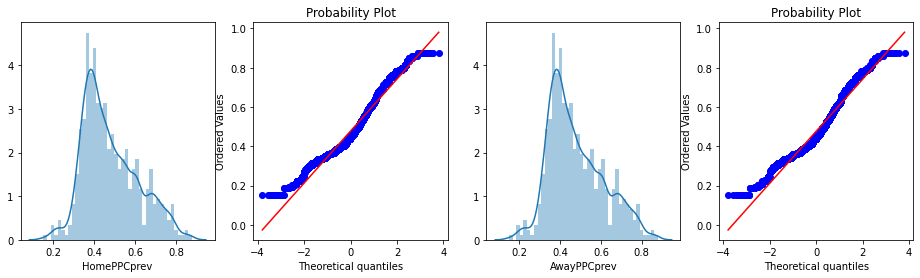

In [46]:
# set up plot size
plt.figure(figsize=(16,4))

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomePPCprev'], dist=norm, plot=plt)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayPPCprev'], dist=norm, plot=plt)

In [47]:
EPL

,Season,HomeTeam,AwayTeam,FTR,HomePPC,AwayPPC,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5,HomePPCprev_tf,AwayPPCprev_tf
0,0,Aston Villa,Man United,H,0.552632,0.719298,0.315036,0.773772,13.0,12.0,-2.040683,-0.288763
1,0,Blackburn,QPR,H,0.535088,0.289474,0.564167,0.354890,13.0,4.0,-0.750418,-1.718786
2,0,Chelsea,Everton,D,0.438596,0.535088,0.486318,0.715456,13.0,6.0,-1.017551,-0.391239
3,0,Liverpool,Sheffield Weds,H,0.622807,0.350877,0.682808,0.455037,6.0,7.0,-0.455879,-1.149324
4,0,Man City,Tottenham,D,0.333333,0.535088,0.235291,0.762666,8.0,2.0,-2.993257,-0.307126
...,...,...,...,...,...,...,...,...,...,...,...,...
9495,24,Leicester,Man United,A,0.543860,0.578947,0.456140,0.578947,7.0,11.0,-1.144383,-0.707460
9496,24,Man City,Norwich,H,0.710526,0.184211,0.859649,0.327055,12.0,0.0,-0.162093,-1.935734
9497,24,Newcastle,Liverpool,A,0.385965,0.868421,0.394737,0.850877,2.0,10.0,-1.459220,-0.173913
9498,24,Southampton,Sheffield United,H,0.456140,0.473684,0.342105,0.604817,9.0,7.0,-1.814251,-0.637100


### 11. LDA

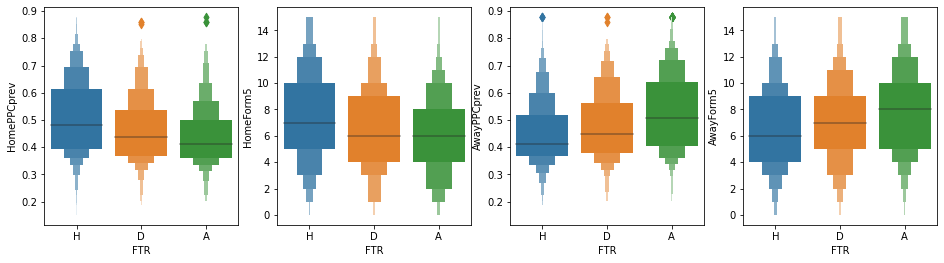

In [48]:
# set up plot size
plt.figure(figsize=(16,4))

ax1 = plt.subplot(141)
plot1=sns.boxenplot(EPL['FTR'], EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2=sns.boxenplot(EPL['FTR'], EPL['HomeForm5'])
ax3 = plt.subplot(143)
plot3=sns.boxenplot(EPL['FTR'], EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4=sns.boxenplot(EPL['FTR'], EPL['AwayForm5'])

In [49]:
kf = KFold(n_splits=4, random_state=2, shuffle=True)
lda_mod = lda()
X1 = EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
y1 = EPL['FTR'].values
scores = cross_val_score(lda_mod, X1, y1, scoring='accuracy', cv=kf, n_jobs=-1)

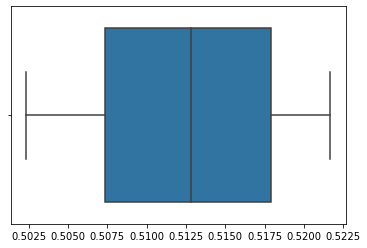

In [50]:
np.std(scores)
np.mean(scores)
sns.boxplot(scores)

In [245]:
# function to fit data to given model and predict values for validation data
def model_fit_predict(model, trainx, trainy, valx):
    # fit training data to model
    model.fit(trainx, trainy)
    # get class predictions and class probabilities
    preds_mod = model.predict(valx)
    probs_mod = model.predict_proba(valx)
    # return class predictions and class probabilities
    return model, preds_mod, probs_mod

In [233]:
# function to perform one hot encoding on class vector in string format 
def myOneHotEncoder(targets):
    le = LabelEncoder() # define label encoder object
    targets_num = le.fit_transform(targets) # generate numeric vector corresponding to classes
    enc = OneHotEncoder() # define one hot encoder object
    return enc.fit_transform(targets_num.reshape(-1, 1)).toarray() # return one hot encoded array

In [224]:
# function to calculate reference probabilities based off class proportions in training data
def get_ref_probs(targets, classes, trainy):
    N = len(targets) # number of observations
    probs0 = np.array([0.0]*len(classes)) # create vector of 0s, length equal to number of classes
    
    # loop through each class
    for i in range(len(classes)):
        probs0[i] = len(trainy[trainy==classes[i]])/len(trainy) # calculate proportion of current class in the training data
    
    probs = np.array([probs0,]*N) # create array of length num.observations with reference probabilities repeated
    
    return probs

In [251]:
# function to calculate ranked probability score
# both targets and probs must be ordered appropriately (e.g. A,D,H or H,D,A)
def rps(targets, probs):
    targets = myOneHotEncoder(targets) # use one hot encoding to convert target vector to binary array
    RPS = 0
    N = targets.shape[0] # number of observations
    r = targets.shape[1] # number of classes
    
    for t in range(N): # loop through all rows (observations)
        for i in range(r-1): # loop through classes (minus the final class)
            inner_sum = 0 # initialise the inner sum value as 0
            
            for j in range(i+1): # loop from 0 to i+1
                inner_sum += (probs[t, j] - targets[t, j]) # add difference between current prob. and target value to inner sum
                
            RPS += inner_sum**2 # square inner sum value after completion of inner loop
            
    RPS = RPS/((r-1)*N) # divide RPS by num.classes-1, and also by num.observations
    
    return RPS

In [243]:
# calculate ranked probability skill score
def rpss(rps, rps_ref):
    return 1 - (rps/rps_ref)

In [256]:
# function to fit model and evaluate on validation data using RPS/RPSS
# (Ranked Probability Score / Ranked Probability Skill Score)
def fit_eval_rps(model, trainx, trainy, valx, valy):
    # predict classes and get class probabilities for validation data
    model, preds_mod, probs_mod = model_fit_predict(model, trainx, trainy, valx)
    
    # get ranked probability score for the validation data using predicted classes
    RPS = rps(valy, probs_mod)
    
    # get probabilities for reference case where training data proportions are used
    ref_probs = get_ref_probs(valy, np.unique(trainy), trainy)
    # get ranked probability skill score for the validation data using predicted classes
    RPS_ref = rps(valy, ref_probs)
    RPSS = rpss(RPS, RPS_ref)
    # return class. accuracy values 
    return RPS, RPSS

In [286]:
num_folds = 10
num_models = 8

rf_params = np.array([[400, 6], [500, 6], [600, 6], [700, 6],
                      [800, 6], [900, 6], [1000, 6], [1100, 6]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

rf_rps = np.zeros(shape=[num_folds,num_models])
rf_rpss = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### Random Forest ###
    # create random forest model
    for j in range(num_models):
        rf_mod = rf(n_estimators=rf_params[j,0], max_depth=rf_params[j,1], random_state=0)
        rf_rps[k,j], rf_rpss[k,j] = fit_eval_rps(rf_mod, train_x, train_y, val_x, val_y)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


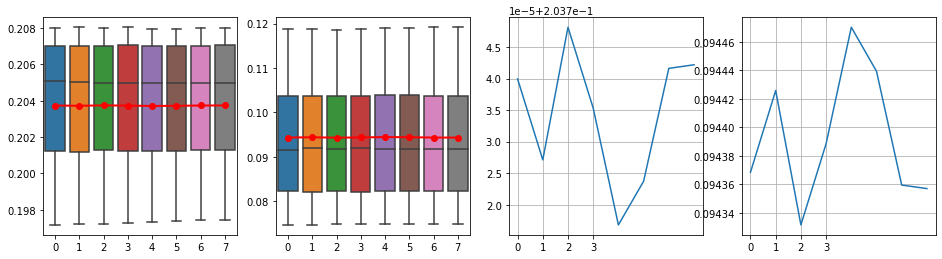

In [333]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=rf_rps)
ax1.plot(np.mean(rf_rps, axis=0),'r-o',linewidth=2)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=rf_rpss)
ax2.plot(np.mean(rf_rpss, axis=0),'r-o',linewidth=2)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(rf_rps, axis=0))
ax3.set_xticks(range(num_models))
plt.grid()
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(rf_rpss, axis=0))
ax4.set_xticks(range(num_models))
plt.grid()

In [309]:
num_folds = 10
num_models = 4

boost_params = np.array([[15, 6], [20, 6], [25, 6], [30, 6]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

boost_rps = np.zeros(shape=[num_folds,num_models])
boost_rpss = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### Boosting ###
    # create gradient boosting model
    for j in range(num_models):
        boost_mod = boost(n_estimators=boost_params[j,0], max_depth=boost_params[j,1], random_state=0)
        boost_rps[k,j], boost_rpss[k,j] = fit_eval_rps(boost_mod, train_x, train_y, val_x, val_y)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


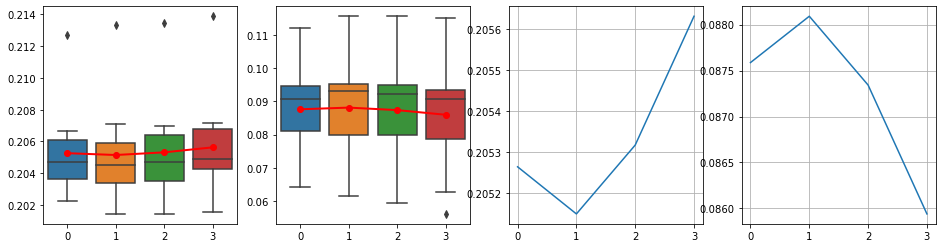

In [310]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=boost_rps)
ax1.plot(np.mean(boost_rps, axis=0),'r-o',linewidth=2)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=boost_rpss)
ax2.plot(np.mean(boost_rpss, axis=0),'r-o',linewidth=2)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(boost_rps, axis=0))
ax3.set_xticks(range(num_models))
plt.grid()
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(boost_rpss, axis=0))
ax4.set_xticks(range(num_models))
plt.grid()

In [328]:
num_folds = 10
num_models = 16

knn_params = np.array(list(range(110,270,10)))

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

knn_rps = np.zeros(shape=[num_folds,num_models])
knn_rpss = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### KNN ###
    # create knn model
    for j in range(num_models):
        knn_mod = knn(n_neighbors=knn_params[j])
        knn_rps[k,j], knn_rpss[k,j] = fit_eval_rps(knn_mod, train_x, train_y, val_x, val_y)

    print(k)

0
1
2
3
4
5
6
7
8
9


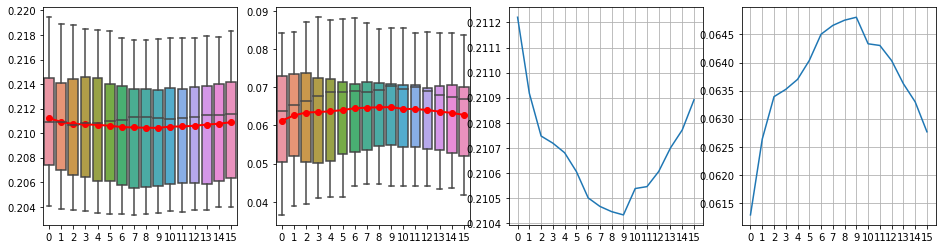

In [329]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=knn_rps)
ax1.plot(np.mean(knn_rps, axis=0),'r-o',linewidth=2)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=knn_rpss)
ax2.plot(np.mean(knn_rpss, axis=0),'r-o',linewidth=2)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(knn_rps, axis=0))
ax3.set_xticks(range(num_models))
plt.grid()
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(knn_rpss, axis=0))
ax4.set_xticks(range(num_models))
plt.grid()

In [356]:
num_folds = 10
num_models = 3

svm_params = np.array([[0.01, 10], [0.001, 10], [0.0001, 10]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

svm_rps = np.zeros(shape=[num_folds,num_models])
svm_rpss = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### SVM ###
    # create rbf SVM model
    for j in range(num_models):
        svm_mod = svm.SVC(kernel='rbf', random_state=1, gamma=svm_params[j,0], C=svm_params[j,0], probability=True)
        svm_rps[k,j], svm_rpss[k,j] = fit_eval_rps(svm_mod, train_x, train_y, val_x, val_y)

    print(k)

0
1
2
3
4
5
6
7
8
9


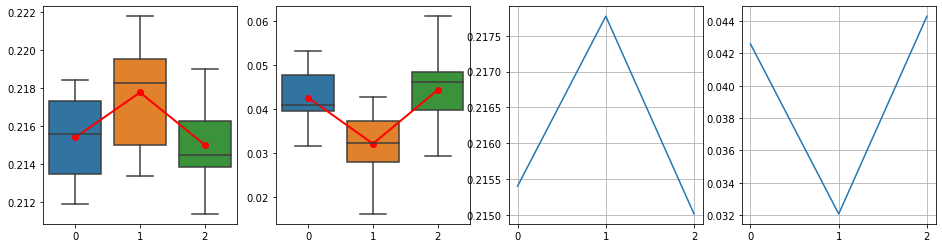

In [357]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=svm_rps)
ax1.plot(np.mean(svm_rps, axis=0),'r-o',linewidth=2)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=svm_rpss)
ax2.plot(np.mean(svm_rpss, axis=0),'r-o',linewidth=2)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(svm_rps, axis=0))
ax3.set_xticks(range(num_models))
plt.grid()
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(svm_rpss, axis=0))
ax4.set_xticks(range(num_models))
plt.grid()

In [360]:
num_folds = 10
num_models = 6

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

models_rps = np.zeros(shape=[num_folds,num_models])
models_rpss = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### LDA ###
    # create LDA model
    lda_mod = lda()
    models_rps[k,0], models_rpss[k,0] = fit_eval_rps(lda_mod, train_x, train_y, val_x, val_y)
        
    ### Random Forest ###
    # create random forest model
    rf_mod = rf(n_estimators=800, max_depth=6, random_state=0)
    models_rps[k,1], models_rpss[k,1] = fit_eval_rps(rf_mod, train_x, train_y, val_x, val_y)
    
    ### SVM ###
    # create rbf SVM model
    svm_mod = svm.SVC(kernel='rbf', random_state=0, gamma=0.0001, C=10, probability=True)
    models_rps[k,2], models_rpss[k,2] = fit_eval_rps(svm_mod, train_x, train_y, val_x, val_y)
       
    ### Boosting ###
    # create boosting model
    boost_mod = boost(n_estimators=20, max_depth=6, random_state=0)
    models_rps[k,3], models_rpss[k,3] = fit_eval_rps(boost_mod, train_x, train_y, val_x, val_y)
    
    ### QDA ###
    # create QDA model
    qda_mod = qda()
    models_rps[k,4], models_rpss[k,4] = fit_eval_rps(qda_mod, train_x, train_y, val_x, val_y)
    
    ### KNN ###
    # create knn model
    knn_mod = knn(n_neighbors=200)
    models_rps[k,5], models_rpss[k,5] = fit_eval_rps(knn_mod, train_x, train_y, val_x, val_y)

    print(k)

0
1
2
3
4
5
6
7
8
9


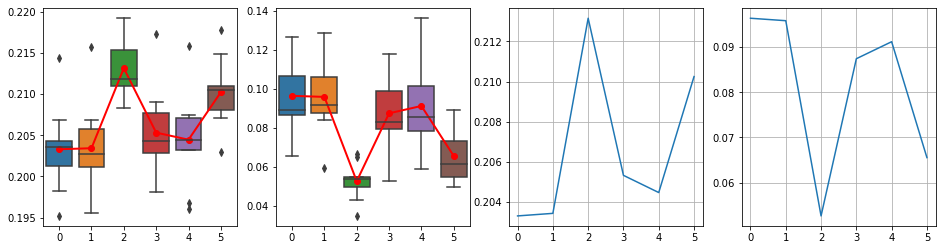

In [361]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=models_rps)
ax1.plot(np.mean(models_rps, axis=0),'r-o',linewidth=2)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=models_rpss)
ax2.plot(np.mean(models_rpss, axis=0),'r-o',linewidth=2)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(models_rps, axis=0))
ax3.set_xticks(range(num_models))
plt.grid()
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(models_rpss, axis=0))
ax4.set_xticks(range(num_models))
plt.grid()

In [52]:
 # function to get class. accuracy for predicted classes
def preds_class_acc(preds, valy):
    # create confusion matrix of actual classes vs predicted classes
    tab = metrics.confusion_matrix(valy, preds)
    # return classification accuracy
    return tab.diagonal().sum()/tab.sum()

# function to get class. accuracy for classes sampled from probabilities
def probs_class_acc(model, probs_mod, num_runs, valy):
    # create vector of 0s
    class_acc_vec = [0] * num_runs
    
    # run through for loop for the number of runs specified
    for run in range(num_runs):
        # create empty vector to store sampled class values (string type)
        mypreds = [""] * probs_mod.shape[0]
        
        # loop through each row of the class probabilities matrix
        for i in range(probs_mod.shape[0]):
            # sample the class using the associated class probabilities
            mypreds[i] = random.choices(model.classes_, probs_mod[i,:], k=1)[0]

        # get class. accuracy for the current sampled classes
        class_acc_vec[run] = preds_class_acc(valy, mypreds)
    # return mean value of class accuracy from all runs
    return np.mean(class_acc_vec)

# function combines all functions above to fit model, predict classes and get class
# probabilities, and calculate class. accuracy values for predicted and sampled classes
def fit_preds_probs(model, trainx, trainy, valx, valy, num_runs):
    # predict classes and get class probabilities for validation data
    model, preds_mod, probs_mod = model_fit_predict(model, trainx, trainy, valx)
    # get class. accuracy for the validation data using predicted classes
    class_acc_pred = preds_class_acc(preds_mod, valy)
    # get class. accuracy for the validation data using sampled classes
    class_acc_prob = probs_class_acc(model, probs_mod, num_runs, valy)
    # return class. accuracy values 
    return class_acc_pred, class_acc_prob

In [457]:
num_folds = 10
folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

preds_vec_lda = [0] * num_folds
predsrand_vec_lda = [0] * num_folds
preds_vec_rf = [0] * num_folds
predsrand_vec_rf = [0] * num_folds
preds_vec_boost = [0] * num_folds
predsrand_vec_boost = [0] * num_folds
preds_vec_boost2 = [0] * num_folds
predsrand_vec_boost2 = [0] * num_folds
preds_vec_knn = [0] * num_folds
predsrand_vec_knn = [0] * num_folds
#preds_vec_svm = [0] * num_folds
#predsrand_vec_svm = [0] * num_folds
#preds_vec_svm2 = [0] * num_folds
#predsrand_vec_svm2 = [0] * num_folds

for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### LDA ###
    # create LDA model
    lda_mod = lda()
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_lda[k], predsrand_vec_lda[k] = fit_preds_probs(lda_mod, train_x, train_y, val_x, val_y, 100)
        
    ### Random Forest ###
    # create random forest model
    rf_mod = rf(random_state=0)   
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_rf[k], predsrand_vec_rf[k] = fit_preds_probs(rf_mod, train_x, train_y, val_x, val_y, 100)
       
    ### Boosting ###
    # create boosting model
    boost_mod = boost(random_state=0)
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_boost[k], predsrand_vec_boost[k] = fit_preds_probs(boost_mod, train_x, train_y, val_x, val_y, 100)
    
    ### KNN ###
    # create knn model
    knn_mod = knn(n_neighbors=20)
    # get class. accuracy for the validation data using predicted classes and sampled classes
    preds_vec_knn[k], predsrand_vec_knn[k] = fit_preds_probs(knn_mod, train_x, train_y, val_x, val_y, 100)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


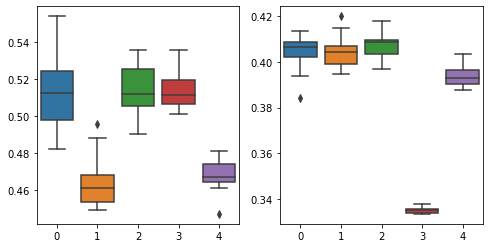

In [458]:
# set up plot size
plt.figure(figsize=(8,4))

# plot boxplots
ax1 = plt.subplot(121)
plot1 = sns.boxplot(data = [preds_vec, preds_vec_rf, preds_vec_boost, preds_vec_boost2, preds_vec_knn])
ax2 = plt.subplot(122)
plot2 = sns.boxplot(data = [predsrand_vec, predsrand_vec_rf, predsrand_vec_boost, predsrand_vec_boost2, predsrand_vec_knn])

In [543]:
num_folds = 10
num_models = 16

rf_params = np.array([[200, 6], [400, 6], [600, 6], [800, 6],
         [200, 7], [400, 7], [600, 7], [800, 7],
         [200, 9], [400, 9], [600, 9], [800, 9],
         [200, 11], [400, 11], [600, 11], [800, 11]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

rf_pred_array = np.zeros(shape=[num_folds,num_models])
rf_prob_array = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### Random Forest ###
    # create random forest model
    for j in range(num_models):
        rf_mod = rf(n_estimators=rf_params[j,0], max_depth=rf_params[j,1], random_state=0)
        rf_pred_array[k,j], rf_prob_array[k,j] = fit_preds_probs(rf_mod, train_x, train_y, val_x, val_y, 100)
    
    print(k)

0
1
2
3
4
5
6
7
8
9


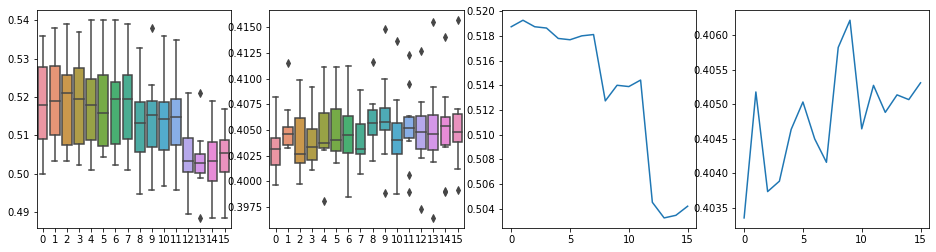

In [544]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=rf_pred_array)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=rf_prob_array)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(rf_pred_array, axis=0))
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(rf_prob_array, axis=0))

In [72]:
num_folds = 10
num_models = 16

boost_params = np.array([[200, 8], [400, 8], [600, 8], [800, 8],
         [500, 10], [750, 10], [1000, 10], [1500, 10],
         [500, 12], [750, 12], [1000, 12], [1500, 12],
         [500, 15], [750, 15], [1000, 15], [1500, 15]])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

boost_pred_array = np.zeros(shape=[num_folds,num_models])
boost_prob_array = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    print("Fold",k,"started.")
    
    ### Random Forest ###
    # create boosting model
    for j in range(num_models):
        boost_mod = boost(n_estimators=boost_params[j,0], max_depth=boost_params[j,1], random_state=0)
        boost_pred_array[k,j], boost_prob_array[k,j] = fit_preds_probs(boost_mod, train_x, train_y, val_x, val_y, 100)
        print("Fold",k,", model",j,"completed.")
    
    #print(k)

Fold 0 started.
Fold 0 , model 0 completed.
Fold 0 , model 1 completed.
Fold 0 , model 2 completed.
Fold 0 , model 3 completed.
Fold 0 , model 4 completed.
Fold 0 , model 5 completed.
Fold 0 , model 6 completed.
Fold 0 , model 7 completed.
Fold 0 , model 8 completed.
Fold 0 , model 9 completed.
Fold 0 , model 10 completed.
Fold 0 , model 11 completed.
Fold 0 , model 12 completed.
Fold 0 , model 13 completed.
Fold 0 , model 14 completed.
Fold 0 , model 15 completed.
Fold 1 started.
Fold 1 , model 0 completed.
Fold 1 , model 1 completed.
Fold 1 , model 2 completed.
Fold 1 , model 3 completed.
Fold 1 , model 4 completed.
Fold 1 , model 5 completed.
Fold 1 , model 6 completed.
Fold 1 , model 7 completed.
Fold 1 , model 8 completed.
Fold 1 , model 9 completed.
Fold 1 , model 10 completed.
Fold 1 , model 11 completed.
Fold 1 , model 12 completed.
Fold 1 , model 13 completed.
Fold 1 , model 14 completed.
Fold 1 , model 15 completed.
Fold 2 started.
Fold 2 , model 0 completed.
Fold 2 , model 1

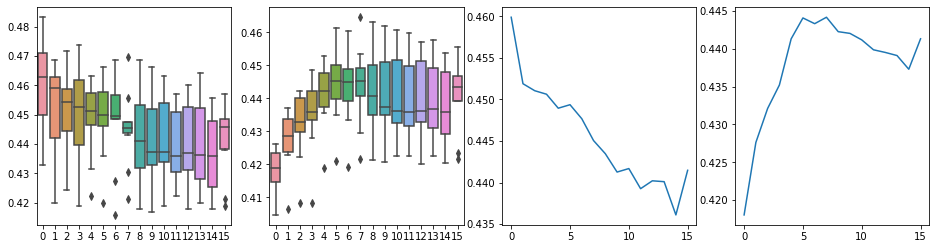

In [73]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=boost_pred_array)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=boost_prob_array)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(boost_pred_array, axis=0))
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(boost_prob_array, axis=0))

In [67]:
num_folds = 10
num_models = 16

knn_params = np.array([3, 5, 7, 9, 11, 13, 15, 17,
         19, 21, 23, 25, 27, 29, 31, 33])

folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

knn_pred_array = np.zeros(shape=[num_folds,num_models])
knn_prob_array = np.zeros(shape=[num_folds,num_models])


for k in range(num_folds):
    # use current fold as the current validation set
    val_fold = folds[k]
    val_x = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    val_y = val_fold['FTR'].values
    
    # combine remaining folds to use as current training set
    train_ind_list = list(range(num_folds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    train_x = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    train_y = train_fold['FTR'].values
    
    ### KNN ###
    # create knn model
    for j in range(num_models):
        knn_mod = knn(n_neighbors=knn_params[j])
        knn_pred_array[k,j], knn_prob_array[k,j] = fit_preds_probs(knn_mod, train_x, train_y, val_x, val_y, 100)

Fold 0 started.
Fold 1 started.
Fold 2 started.
Fold 3 started.
Fold 4 started.
Fold 5 started.
Fold 6 started.
Fold 7 started.
Fold 8 started.
Fold 9 started.


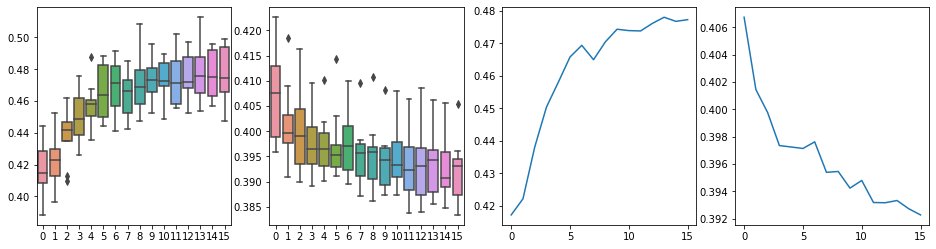

In [69]:
# set up plot size
plt.figure(figsize=(16,4))

# plot boxplots
ax1 = plt.subplot(141)
plot1 = sns.boxplot(data=knn_pred_array)
ax2 = plt.subplot(142)
plot2 = sns.boxplot(data=knn_prob_array)
# plot mean values
ax3 = plt.subplot(143)
plot3 = plt.plot(np.mean(knn_pred_array, axis=0))
ax4 = plt.subplot(144)
plot4 = plt.plot(np.mean(knn_prob_array, axis=0))

Mean: 0.40913684210526313


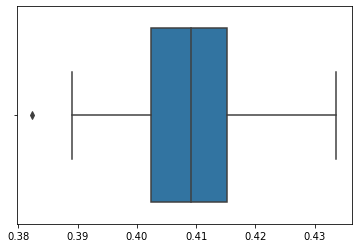

In [395]:
num_runs = 100
class_acc_vec = [0] * num_runs

for k in range(num_runs):
    mypreds = [""] * probs_lda.shape[0]

    for i in range(probs_lda.shape[0]):    
        mypreds[i] = random.choices(lda_mod.classes_, probs_lda[i,:], k=1)[0]

    tab = metrics.confusion_matrix(ytest1, mypreds)
    
    class_acc_vec[k] = tab.diagonal().sum()/tab.sum()

print('Mean:', np.mean(class_acc_vec))

sns.boxplot(class_acc_vec)

Mean: 0.39981768421052627


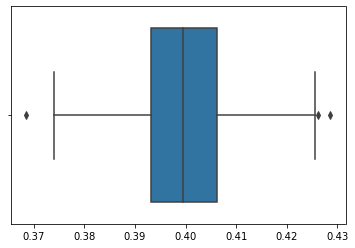

In [226]:
num_runs = 1000
class_acc_vec = [0] * num_runs

for k in range(num_runs):
    mypreds = [""] * probs_lda.shape[0]

    for i in range(probs_lda.shape[0]):    
        mypreds[i] = random.choices(lda_mod.classes_, probs_lda[i,:], k=1)[0]

    tab = metrics.confusion_matrix(ytest1, mypreds)
    
    class_acc_vec[k] = tab.diagonal().sum()/tab.sum()

print('Mean:', np.mean(class_acc_vec))

sns.boxplot(class_acc_vec)

Mean: 0.3336606315789474


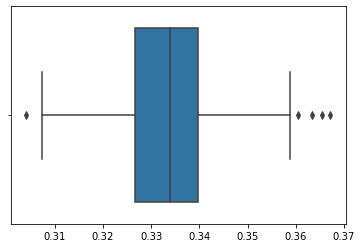

In [228]:
num_runs = 1000
class_acc_vec = [0] * num_runs

for k in range(num_runs):
    mypreds = [""] * probs_lda.shape[0]

    for i in range(probs_lda.shape[0]):    
        mypreds[i] = random.choices(lda_mod.classes_, [1/3,1/3,1/3], k=1)[0]

    tab = metrics.confusion_matrix(ytest1, mypreds)
    
    class_acc_vec[k] = tab.diagonal().sum()/tab.sum()

print('Mean:', np.mean(class_acc_vec))

sns.boxplot(class_acc_vec)

Mean: 0.36222273684210526


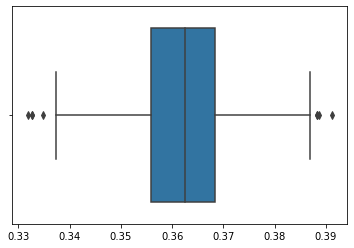

In [235]:
num_runs = 1000
class_acc_vec = [0] * num_runs

for k in range(num_runs):
    mypreds = [""] * probs_lda.shape[0]

    for i in range(probs_lda.shape[0]):    
        mypreds[i] = random.choices(lda_mod.classes_, [2031/7125,1831/7125,3263/7125], k=1)[0]

    tab = metrics.confusion_matrix(ytest1, mypreds)
    
    class_acc_vec[k] = tab.diagonal().sum()/tab.sum()

print('Mean:', np.mean(class_acc_vec))

sns.boxplot(class_acc_vec)